# HW6-1: Transfer learning on pretrained VGG 16.

- The code in this notebook was generated using [GitHub Copilot](https://github.com/features/copilot).

## Prompt

Generate a PyTorch Lightning script for Face-Mask-Detection using:

- Following crisp-dm steps.
- Dataset: load the Face-Mask-Detection dataset from "Face-Mask-Detection-/facemask" using PyTorch ImageFolder.
- Model: Pre-trained VGG16 from ImageNet. Replace the final layer to classify 2 classes (with mask, without mask).
- Loss: Cross-entropy.
- Metrics: Track training, validation, and test accuracy using torchmetrics.
- Optimizer: AdamW with CosineAnnealingLR scheduler.
- Logger: TensorBoardLogger.
- Callbacks: LearningRateMonitor, TQDMProgressBar.
- Training: Train for 5 epochs, batch size 128, learning rate 1e-5.
- Visualization: Visualize the training set images with their label.
- Evaluation: Visualize the test set images with their true and predicted labels.
- Deployment: Allow program to input image url, then classify which class it is.

In [20]:
%load_ext tensorboard

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
import torchmetrics
import matplotlib.pyplot as plt

### Prepare and visualize the dataset

/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


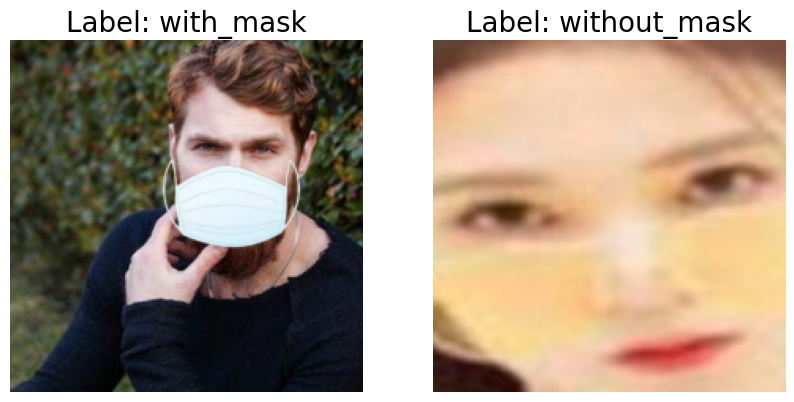

In [2]:
# Data preparation for Face Mask Detection
def prepare_data(base_dir="Face-Mask-Detection-/facemask"):
    # Define the image transformation (resize, normalization)
    transform = models.VGG16_Weights.IMAGENET1K_V1.transforms()

    # Load datasets using ImageFolder
    train_dataset = datasets.ImageFolder(f"{base_dir}/train", transform=transform)
    valid_dataset = datasets.ImageFolder(f"{base_dir}/valid", transform=transform)
    test_dataset = datasets.ImageFolder(f"{base_dir}/test", transform=transform)
    
    # Get classes from the dataset (these will be 'with_mask' and 'without_mask')
    classes = train_dataset.classes
    
    # Load data into DataLoader
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=128)
    test_loader = DataLoader(test_dataset, batch_size=128)

    return classes, train_loader, val_loader, test_loader

# Display sample images from the dataset
def display_sample_images(dataset, classes):
    """
    Display one sample image and its label from each class in the dataset.
    """
    class_examples = {}
    for img, label in dataset:
        if label not in class_examples:
            class_examples[label] = img
        if len(class_examples) == len(classes):  # We have all classes
            break
        
    # Reverse the normalization for visualization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

    # Plot the images with their labels
    fig, axes = plt.subplots(1, len(classes), figsize=(10, 10))
    for i, class_label in enumerate(classes):
        img = unnormalize(class_examples[i])
        axes[i].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axes[i].set_title(f"Label: {class_label}")
        axes[i].title.set_fontsize(20)
        axes[i].axis("off")
    plt.show()

# Prepare data
classes, train_loader, val_loader, test_loader = prepare_data()

# Display sample images
display_sample_images(train_loader.dataset, classes)

### Modeling
- Load the pre-trained VGG16 model from torchvision.models.
- Replace the final layer to classify 2 classes (with mask and without mask).

In [3]:
class VGG16Model(pl.LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        self.learning_rate = learning_rate

        # Load the pre-trained VGG16 model and modify it
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        
        # Modify the final fully connected layer for 2 output classes (with_mask, without_mask)
        self.model.classifier[6] = nn.Linear(4096, 2)

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.train_acc(logits.softmax(dim=-1), y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.val_acc(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.test_acc(logits.softmax(dim=-1), y)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", acc, prog_bar=True, on_step=False, on_epoch=True)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        class_ = self(x)
        y_hat = class_.argmax(dim=-1)
        return y_hat, y, x

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs)
        return [optimizer], [scheduler]

### Train the model
- train on the training set
- validate on the validation set

In [4]:
# Logger and Callbacks
logger = TensorBoardLogger(
    "logs6-1",
    name="facemask_vgg16",
)
lr_monitor = LearningRateMonitor(logging_interval="epoch")
progress_bar = TQDMProgressBar(leave=True)

# Train the model
model = VGG16Model(learning_rate=1e-5)
trainer = pl.Trainer(
    max_epochs=5,
    logger=logger,
    callbacks=[lr_monitor, progress_bar],
    log_every_n_steps=10,
)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-12-20 00:10:42.957015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-20 00:10:42.966675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-20 00:10:42.969562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 00:10:42.977117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other opera

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]
Epoch 0:  59%|█████▉    | 20/34 [00:12<00:08,  1.58it/s, v_num=0]

/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4: 100%|██████████| 34/34 [00:22<00:00,  1.52it/s, v_num=0, val_loss=0.0148, val_acc=0.997, train_loss=0.0041, train_acc=0.998] 


`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   0.002114869887009263    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.002114869887009263, 'test_acc': 1.0}]

### Evaluate the model and visualize the results
- test on the test set

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/g113056077/.pyenv/versions/aiot-hw5/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


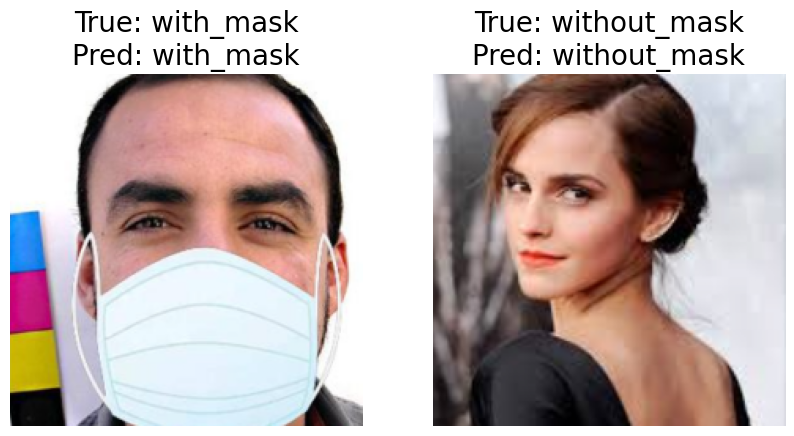

In [5]:
# Function to display one sample image per class along with true and predicted labels
def display_prediction_examples(model, dataloader, classes):
    # Collect results from the prediction
    predictions = trainer.predict(model, dataloaders=dataloader)
    
    # Dictionary to store one sample for each class
    class_examples = {i: {'image': None, 'true_label': None, 'pred_label': None} for i in range(10)}

    for y_hat, y, x in predictions:
        for i in range(len(y)):
            label = y[i].item()
            pred_label = y_hat[i].item()

            # Store the first image for each class
            if class_examples[label]['image'] is None:
                class_examples[label]['image'] = x[i]  # Store the image
                class_examples[label]['true_label'] = label
                class_examples[label]['pred_label'] = pred_label

            # Stop once we have one image for each class
            if all(v['image'] is not None for v in class_examples.values()):
                break

        # Stop the loop if all class examples are collected
        if all(v['image'] is not None for v in class_examples.values()):
            break
    
    # Reverse the normalization for visualization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    
    # Plot the images with true and predicted labels
    fig, axes = plt.subplots(1, len(classes), figsize=(10, 10))
    for i, class_label in enumerate(classes):
        img = unnormalize(class_examples[i]['image'].squeeze())
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f"True: {classes[class_examples[i]['true_label']]}\nPred: {classes[class_examples[i]['pred_label']]}")
        axes[i].title.set_fontsize(20)
        axes[i].axis("off")
    plt.show()

# Use the test dataset to display the predictions
display_prediction_examples(model, test_loader, classes)

### Depolyment
- Allow program to input image url, then classify which class it is.

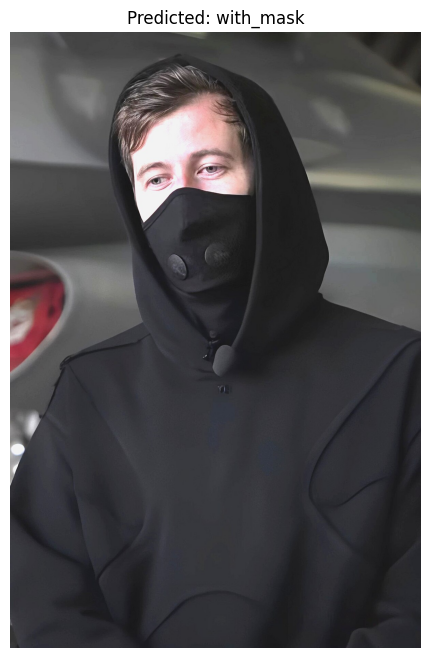

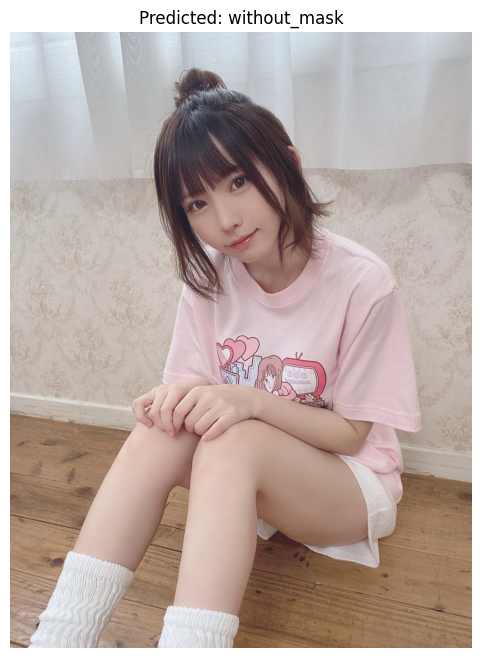

In [18]:
from PIL import Image
import requests
from io import BytesIO

def predict_from_url(model, url, classes):
    # Download the image
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_original = img.copy()

    # Apply the same transformations as the training data
    transform = models.VGG16_Weights.IMAGENET1K_V1.transforms()
    img = transform(img).unsqueeze(0)  # Add batch dimension

    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(img)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predicted_class = probabilities.argmax(dim=1).item()

    # Display the image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img_original)
    plt.title(f"Predicted: {classes[predicted_class]}")
    plt.axis('off')
    plt.show()

# Example usage
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Alan_Walker_visits_Spangdahlem.jpg/1200px-Alan_Walker_visits_Spangdahlem.jpg"
predict_from_url(model, url, classes)

url = "https://pbs.twimg.com/media/Fe8RQG9aUAE1_RS?format=jpg&name=large"
predict_from_url(model, url, classes)



In [22]:
%tensorboard --logdir "logs6-1"

Reusing TensorBoard on port 6006 (pid 27821), started 0:00:13 ago. (Use '!kill 27821' to kill it.)